<a href="https://colab.research.google.com/github/ramya-njn/Transformers-BERT-Fine-Tuning/blob/main/Fine_Tuning_BERT_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dataset** : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv

## 1. Install and Import Libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn

import transformers
from transformers import AutoModel, AutoTokenizer, AdamW

## 2. Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Fine_Tuning_Transformer_PyTorch')

In [5]:
!pwd

/content/drive/MyDrive/Fine_Tuning_Transformer_PyTorch


In [6]:
tweets = pd.read_csv('Tweets.csv')
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
tweets = tweets[['text','airline_sentiment']]
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
tweets.shape

(14640, 2)

In [9]:
data = tweets.sample(frac=0.5, random_state=42).reset_index(drop=True)
print(data.shape)
data.head()

(7320, 2)


,text,airline_sentiment
0,@SouthwestAir you're my early frontrunner for ...,positive
1,@USAirways how is it that my flt to EWR was Ca...,negative
2,@JetBlue what is going on with your BDL to DCA...,negative
3,@JetBlue do they have to depart from Washingto...,neutral
4,@JetBlue I can probably find some of them. Are...,negative


In [10]:
data.isna().apply(pd.value_counts)

,text,airline_sentiment
False,7320,7320


In [11]:
sentiment_labels = {'negative': 2, 'positive': 1, 'neutral': 0}

data['airline_sentiment'] =  data['airline_sentiment'].replace(sentiment_labels)
data = data.rename(columns = {'airline_sentiment': 'label'})
data.head()

,text,label
0,@SouthwestAir you're my early frontrunner for ...,1
1,@USAirways how is it that my flt to EWR was Ca...,2
2,@JetBlue what is going on with your BDL to DCA...,2
3,@JetBlue do they have to depart from Washingto...,0
4,@JetBlue I can probably find some of them. Are...,2


In [12]:
# Check Label distribution

label_counts= data['label'].value_counts().reset_index()
label_counts

,label,count
0,2,4634
1,0,1510
2,1,1176


<Axes: xlabel='label', ylabel='count'>

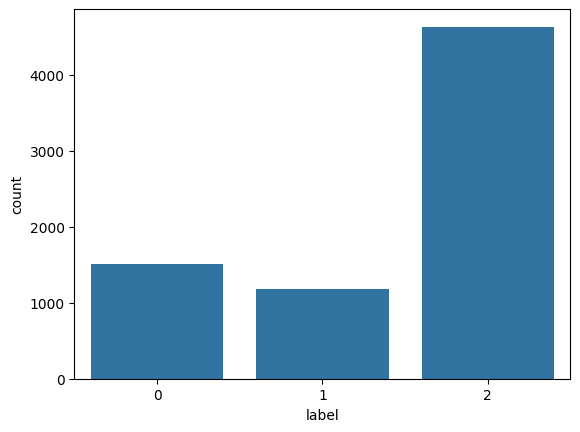

In [13]:
sns.barplot(x='label', y='count', data=label_counts)

Minimum Squence Length: 2
Maximum Squence Length: 32


<Axes: >

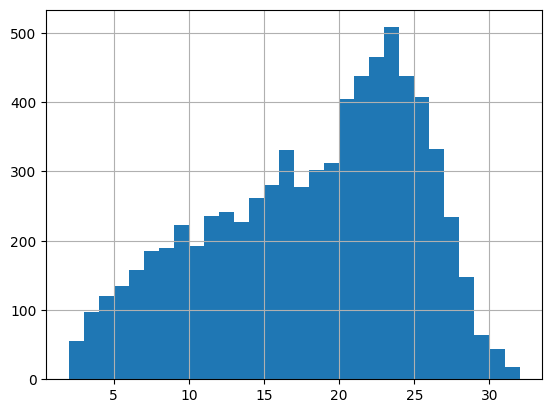

In [14]:
# Check sequence length distribution in text data

seq_len = [len(i.split()) for i in data['text']]

print('Minimum Squence Length:', min(seq_len))
print('Maximum Squence Length:', max(seq_len))

pd.Series(seq_len).hist(bins=30)



## 3. Train, Validation, Test Split

In [15]:
train, test = train_test_split(data, test_size=0.4, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)


(4392, 2)
(1464, 2)
(1464, 2)


## 4. Load Tokenizer and Pretrained Model

In [16]:
model_version = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_version)
model = AutoModel.from_pretrained(model_version)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]






## 4. Create a PyTorch Dataset

In [17]:
class Reviews(Dataset):

  def __init__(self, data, tokenizer, max_length):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    text = self.data.iloc[index]['text']
    label = self.data.iloc[index]['label']
    encoded = tokenizer(text, padding = 'max_length', truncation = True, max_length = self.max_length, return_tensors='pt')
    input_ids = encoded['input_ids'].squeeze(0)
    token_type_ids = encoded['token_type_ids'].squeeze(0)
    attention_mask = encoded['attention_mask'].squeeze(0)
    label = torch.tensor(label).unsqueeze(0)
    return input_ids, token_type_ids, attention_mask, label


In [18]:
train_dataset = Reviews(train, tokenizer, 25)
val_dataset = Reviews(val, tokenizer, 25)
test_dataset = Reviews(test, tokenizer, 25)

In [19]:
# Get the first item from train_dataset
print(train_dataset[0])


(tensor([ 101, 1030, 2142, 2151, 2739, 1029,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), tensor([0]))


In [20]:
# Setup DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, drop_last=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, drop_last=True, shuffle=False)

print('# Train Batches:', len(train_loader))
print('# Validation Batches:', len(val_loader))
print('# Test Batches:', len(test_loader))

# Train Batches: 68
# Validation Batches: 22
# Test Batches: 22


In [21]:
# Check one batch from train_loader

train_out = next(iter(train_loader))
print(len(train_out))
print(train_out)

4
[tensor([[  101,  1030, 25988,  ...,  1012,  2339,   102],
        [  101,  1030,  2142,  ...,  1007,  1998,   102],
        [  101,  1030,  2142,  ...,  2013,  2474,   102],
        ...,
        [  101,  1030,  2142,  ...,  2073,  2026,   102],
        [  101,  1030,  2142,  ...,  2025,  2131,   102],
        [  101,  1030,  2142,  ...,  2071,  2057,   102]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([[2],
        [2],
        [0],
        [2],
        [2],
        [0],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [0],
 

## 5. Create PyTorch Model



In [22]:
class BertClassifierHead(nn.Module):

  def __init__(self, bert_model, num_classes):
    super().__init__()
    self.bert_model = bert_model
    self.head =  nn.Sequential(
        nn.Linear(768, 300),
        nn.ReLU(),
        nn.Linear(300, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, num_classes))

  def forward(self, input_ids, attention_mask):
    x = self.bert_model(input_ids = input_ids, attention_mask = attention_mask)[1]
    out = self.head(x)
    return out


## 6. Model Training

In [23]:
# New Model
bertclassifier = BertClassifierHead(model, 3)

# Training parameters
optimizer = AdamW(bertclassifier.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
epochs = 5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

training_stats = []

for epoch in range(epochs):
  ######## TRAINING #########
  print('\n')
  print(f'=======Epoch {epoch+1}/{epochs}=======')
  print('Training....')
  bertclassifier.train()
  train_loss = 0

  for i, batch in enumerate(train_loader):

    input_ids, token_type_ids, attention_mask, label = batch
    label = label.view(-1)

    optimizer.zero_grad()
    logits = bertclassifier(input_ids, attention_mask)
    loss = loss_fn(logits, label)
    train_loss += loss.item()

    loss.backward()
    optimizer.step()

    if (i+1) % 20 == 0:
      print(f'Batch {i+1}/{len(train_loader)}: loss = {loss.item():.4f}')

  avg_train_loss = train_loss/len(train_loader)
  print(f' Average Training Loss: {avg_train_loss:.4f}')

  ######## VALIDATION #########
  print('Evaluating....')
  bertclassifier.eval()
  val_loss = 0
  val_acc = 0

  for i, batch in enumerate(val_loader):

    input_ids, token_type_ids, attention_mask, label = batch
    label = label.view(-1)

    with torch.no_grad():
      logits = bertclassifier(input_ids, attention_mask)

      loss = loss_fn(logits, label)
      val_loss += loss.item()

      preds = torch.argmax(logits, dim=1)
      accuracy = (preds == label).sum().item()/len(label)
      val_acc += accuracy

  avg_val_loss = val_loss/len(val_loader)
  print(f' Validation Loss: {avg_val_loss:.4f}')

  avg_val_acc = val_acc/len(val_loader)
  print(f' Validation Accuracy: {avg_val_acc:.4f}')
   ################################################

  training_stats.append({'Epoch': epoch+1,
                          'Training Loss': avg_train_loss,
                          'Validation Loss': avg_val_loss,
                          'Validation Accuracy': avg_val_acc})

print('\n')
print('Training Complete!')




=======Epoch 1/5=======
Training....
Batch 20/68: loss = 1.0457
Batch 40/68: loss = 1.0324
Batch 60/68: loss = 0.8421
 Average Training Loss: 1.0074
Evaluating....
 Validation Loss: 0.8455
 Validation Accuracy: 0.7266


=======Epoch 2/5=======
Training....
Batch 20/68: loss = 0.7810
Batch 40/68: loss = 0.6770
Batch 60/68: loss = 0.6181
 Average Training Loss: 0.7271
Evaluating....
 Validation Loss: 0.5981
 Validation Accuracy: 0.8295


=======Epoch 3/5=======
Training....
Batch 20/68: loss = 0.5416
Batch 40/68: loss = 0.6103
Batch 60/68: loss = 0.3966
 Average Training Loss: 0.5343
Evaluating....
 Validation Loss: 0.5114
 Validation Accuracy: 0.8331


=======Epoch 4/5=======
Training....
Batch 20/68: loss = 0.4793
Batch 40/68: loss = 0.4045
Batch 60/68: loss = 0.3595
 Average Training Loss: 0.4004
Evaluating....
 Validation Loss: 0.5090
 Validation Accuracy: 0.8310


=======Epoch 5/5=======
Training....
Batch 20/68: loss = 0.1523
Batch 40/68: loss = 0.3609
Batch 60/68: loss = 0.4375


## 7. Evaluate Model on Test Data

In [25]:
bertclassifier.eval()
test_preds = []
test_labels =[]

for i, batch in enumerate(test_loader):

  input_ids, token_type_ids, attention_mask, label = batch
  label = label.view(-1)

  with torch.no_grad():
    logits = bertclassifier(input_ids, attention_mask)
    preds = torch.argmax(logits, dim=1)
    test_preds.append(preds.numpy())
    test_labels.append(label.numpy())

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)


In [26]:
# Get Matthews Correlation Coefficient

print(matthews_corrcoef(test_labels, test_preds))

0.6802516166823304


In [27]:
# Get classification report

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       291
           1       0.75      0.82      0.78       243
           2       0.90      0.86      0.88       874

    accuracy                           0.82      1408
   macro avg       0.77      0.79      0.78      1408
weighted avg       0.83      0.82      0.82      1408



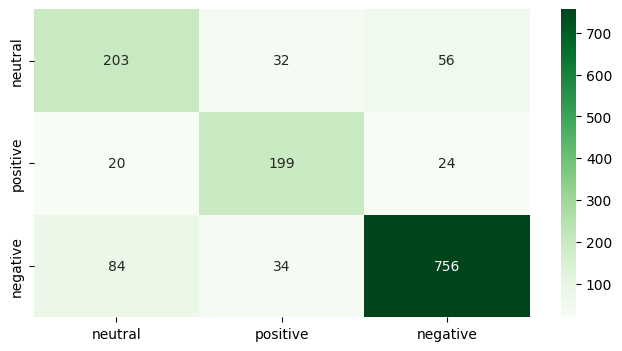

In [28]:
# Get Confusion Matrix

cm = confusion_matrix(test_labels, test_preds)

sentiments = {'neutral': 0, 'positive': 1, 'negative': 2}
names = list(sentiments.keys())

df_cm = pd.DataFrame(cm, index = names, columns = names)
plt.figure(figsize=(8,4))
sns.heatmap(df_cm, annot=True, cmap='Greens', fmt = 'g')
plt.show()

## 8. Save and Load Model

In [29]:
# save model
output_dir = './output'

model_to_save = bertclassifier.module if hasattr(bertclassifier, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./output/tokenizer_config.json',
 './output/special_tokens_map.json',
 './output/vocab.txt',
 './output/added_tokens.json',
 './output/tokenizer.json')

In [30]:
# Load model

model = AutoModel.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)